# RePaint + Negative Prompt Inpainting Demo — Quantitative Evaluation

This notebook evaluates `improved_repaint_negativeprompt.py` on **N images** from the **MS COCO val2017**
dataset, using **MNIST digit silhouettes** as masks (~10% of image).

**Method:** RePaint resampling per timestep (`RESAMPLE_STEPS=5`) with **negative prompt guidance** via CFG.
Unlike `improved_inpaint.py`, there is **no Gaussian soft mask** blending — the mask is applied as a
hard binary mask with nearest-neighbor interpolation to latent resolution.

Results are stored in `eval_results_repaint/` and are directly comparable to the vanilla, improved,
and gaussian notebooks — all notebooks use the **same SEED and N_IMAGES**, so they sample identical
COCO images and MNIST digits.

**Output layout:**
```
eval_results_repaint/
  originals/            ← 0000.png + 0000.json … (written once)
  inpainted/            ← 0000.png … 0099.png
  masks/                ← 0000.pt  … 0099.pt
  checkpoint.json
  metric_distributions.png  ← KDE overlay (repaint+negprompt vs vanilla)
  top10_best.png
  top10_worst.png
```

In [19]:
import sys, os, json
import numpy as np
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_fn
from tqdm.auto import tqdm
import lpips

# ---- Config ----
N_IMAGES       = 2
IMAGE_SIZE     = (512, 512)
SEED           = 42
STEPS          = 50
GUIDANCE_SCALE = 7.5
DATA_ROOT      = "./data"

# RePaint-specific parameters
RESAMPLE_STEPS = 5

RESULTS_DIR         = "./eval_results_repaint"
VANILLA_RESULTS_DIR = "../eval_results"  # read-only: for vanilla comparison

CHECKPOINT = os.path.join(RESULTS_DIR, "checkpoint.json")

COCO_ROOT      = os.path.join(DATA_ROOT, "coco")
COCO_IMG_DIR   = os.path.join(COCO_ROOT, "val2017")
COCO_ANN_FILE  = os.path.join(COCO_ROOT, "annotations", "captions_val2017.json")
COCO_INST_FILE = os.path.join(COCO_ROOT, "annotations", "instances_val2017.json")

os.makedirs(os.path.join(RESULTS_DIR, "originals"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "inpainted"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "masks"),     exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Config: N_IMAGES={N_IMAGES}, SIZE={IMAGE_SIZE}, STEPS={STEPS}, GUIDANCE={GUIDANCE_SCALE}")
print(f"RePaint params: RESAMPLE_STEPS={RESAMPLE_STEPS}")
print(f"Output dir:  {RESULTS_DIR}/{{inpainted,masks}}")
print(f"Vanilla dir: {VANILLA_RESULTS_DIR} (read-only for comparison)")

Config: N_IMAGES=2, SIZE=(512, 512), STEPS=50, GUIDANCE=7.5
RePaint params: RESAMPLE_STEPS=5
Output dir:  ./eval_results_repaint/{inpainted,masks}
Vanilla dir: ./eval_results (read-only for comparison)


In [20]:
import urllib.request
import zipfile

_pbar = None

def reporthook(block_num, block_size, total_size):
    global _pbar
    if _pbar is None:
        _pbar = tqdm(total=total_size, unit="B", unit_scale=True, unit_divisor=1024)
    downloaded = block_num * block_size
    _pbar.n = min(downloaded, total_size)
    _pbar.refresh()
    if downloaded >= total_size:
        _pbar.close()
        _pbar = None

# ---- Download COCO val2017 images (~1 GB) if not present ----
os.makedirs(COCO_ROOT, exist_ok=True)

IMG_URL = "http://images.cocodataset.org/zips/val2017.zip"
ANN_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

if not os.path.isdir(COCO_IMG_DIR):
    img_zip = os.path.join(COCO_ROOT, "val2017.zip")
    print("Downloading COCO val2017 images (~1 GB)...")
    urllib.request.urlretrieve(IMG_URL, img_zip, reporthook)
    print("Extracting images...")
    with zipfile.ZipFile(img_zip) as z:
        z.extractall(COCO_ROOT)
    os.remove(img_zip)
    print("Done.")
else:
    print(f"COCO images already present: {COCO_IMG_DIR}")

if not os.path.exists(COCO_ANN_FILE):
    ann_zip = os.path.join(COCO_ROOT, "annotations_trainval2017.zip")
    print("Downloading COCO annotations (~240 MB)...")
    urllib.request.urlretrieve(ANN_URL, ann_zip, reporthook)
    print("Extracting annotations...")
    with zipfile.ZipFile(ann_zip) as z:
        z.extractall(COCO_ROOT)
    os.remove(ann_zip)
    print("Done.")
else:
    print(f"COCO annotations already present: {COCO_ANN_FILE}")

# ---- Load captions JSON ----
with open(COCO_ANN_FILE, "r") as f:
    coco_data = json.load(f)

coco_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

coco_captions = {}
for ann in coco_data["annotations"]:
    img_id = ann["image_id"]
    coco_captions.setdefault(img_id, []).append(ann["caption"])

# Exclude categories inpainting is very noisy in.
EXCLUDED_SUPERCATEGORIES = {"person", "animal", "sports", "food"}

with open(COCO_INST_FILE, "r") as f:
    inst_data = json.load(f)

excluded_cat_ids = {
    c["id"] for c in inst_data["categories"]
    if c["supercategory"] in EXCLUDED_SUPERCATEGORIES
}
excluded_image_ids = {
    a["image_id"] for a in inst_data["annotations"]
    if a["category_id"] in excluded_cat_ids
}
print(f"Images excluded (person/animal/sports/food): "
      f"{len(excluded_image_ids)} / {len(coco_id_to_filename)}")

# ---- Keep only scene/room/nature/vehicle images with captions on disk ----
valid_ids = [
    img_id for img_id, caps in coco_captions.items()
    if img_id not in excluded_image_ids
    and os.path.exists(os.path.join(COCO_IMG_DIR, coco_id_to_filename[img_id]))
]
print(f"Scene/room/nature/vehicle images remaining: {len(valid_ids)}")

# ---- Sample N_IMAGES image IDs deterministically (same SEED as vanilla) ----
# Using np.random.RandomState ensures the sequence is identical across notebooks
# with the same SEED. Increasing N_IMAGES to 1000 extends the same sequence —
# the first 100 entries are always identical.
rng = np.random.RandomState(SEED)
sampled_ids = rng.choice(valid_ids, size=N_IMAGES, replace=False).tolist()

coco_samples = [
    (coco_id_to_filename[img_id], coco_captions[img_id][0])
    for img_id in sampled_ids
]

# ---- Load MNIST (test set) ----
mnist = torchvision.datasets.MNIST(
    root=DATA_ROOT, train=False, download=True
)

mnist_indices = rng.choice(len(mnist), size=N_IMAGES, replace=False)

print(f"MNIST dataset size:  {len(mnist)}")
print(f"Sampled {N_IMAGES} scene/room/nature/vehicle image-mask pairs.")

COCO images already present: ./data/coco/val2017
COCO annotations already present: ./data/coco/annotations/captions_val2017.json
Images excluded (person/animal/sports/food): 3809 / 5000
Scene/room/nature/vehicle images remaining: 1191
MNIST dataset size:  10000
Sampled 2 scene/room/nature/vehicle image-mask pairs.


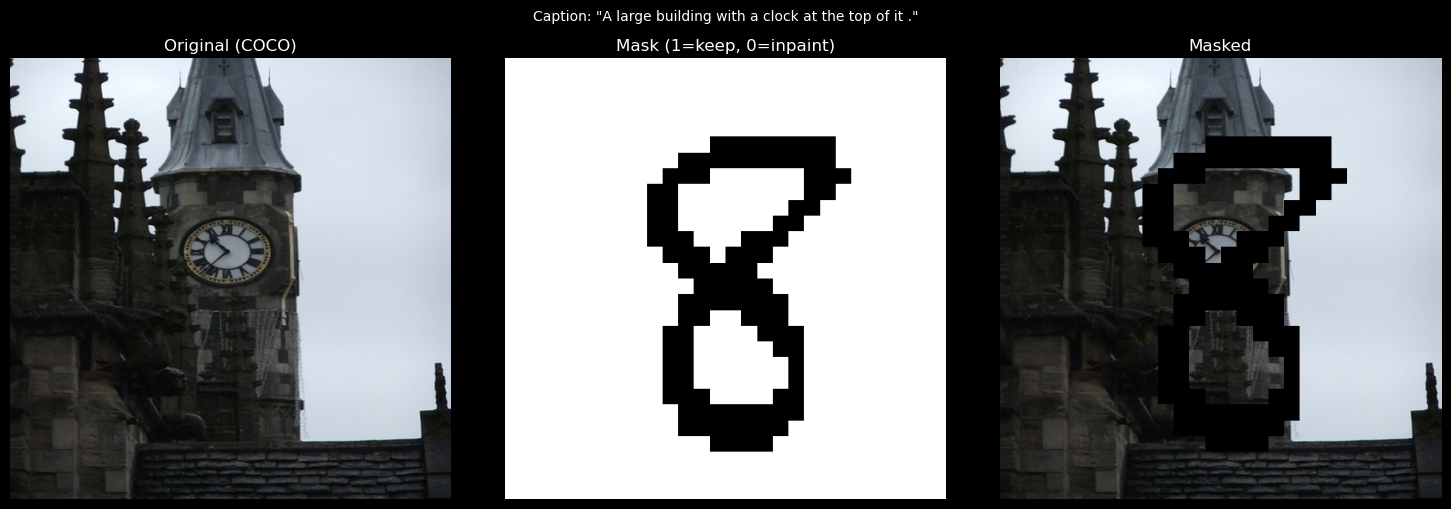

Inpainted region: 13.9% of image


In [21]:
def prepare_mnist_mask(mnist_image, size=IMAGE_SIZE):
    """
    Inpainting mask: digit silhouette is the erased region (~10% of image).
    Convention: 1 = keep, 0 = inpaint.
    Digit pixels (bright >127) -> 0 (inpaint), background -> 1 (keep).

    Returns: torch.Tensor of shape (1, 1, H, W)
    """
    mask_pil = mnist_image.resize(size, Image.NEAREST)
    mask_np = np.array(mask_pil)
    mask_binary = (mask_np <= 127).astype(np.float32)
    return torch.from_numpy(mask_binary).unsqueeze(0).unsqueeze(0)


def prepare_coco_image(path, size=IMAGE_SIZE):
    """Load a COCO image from disk and resize to the target size."""
    return Image.open(path).convert("RGB").resize(size, Image.LANCZOS)


def apply_mask_for_display(image, mask_tensor):
    """Black out the inpainted region for visualization."""
    img_np = np.array(image).copy()
    mask_np = mask_tensor.squeeze().numpy()
    img_np[mask_np == 0] = 0
    return Image.fromarray(img_np)


sample_filename, sample_caption = coco_samples[0]
sample_img   = prepare_coco_image(os.path.join(COCO_IMG_DIR, sample_filename))
sample_digit = mnist[mnist_indices[0]][0]
sample_mask  = prepare_mnist_mask(sample_digit)
sample_masked = apply_mask_for_display(sample_img, sample_mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_img);                          axes[0].set_title("Original (COCO)")
axes[1].imshow(sample_mask.squeeze(), cmap="gray");  axes[1].set_title("Mask (1=keep, 0=inpaint)")
axes[2].imshow(sample_masked);                       axes[2].set_title("Masked")
for ax in axes:
    ax.axis("off")
plt.suptitle(f'Caption: "{sample_caption}"', fontsize=10, y=1.01)
plt.tight_layout()
plt.show()

frac = (sample_mask == 0).float().mean().item() * 100
print(f"Inpainted region: {frac:.1f}% of image")

In [22]:
sys.path.insert(0, os.path.abspath(".."))
from failed_attempts.improved_repaint_negativeprompt import ddpm_inpaint_repaint
from cliutils import load_sd_pipeline

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading model...")
pipe = load_sd_pipeline(device)
pipe.set_progress_bar_config(disable=True)
print("Model loaded.")

Using device: mps
Loading model...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.87it/s]


Model loaded.


In [23]:
# ---- Inpainting loop (erase digit silhouette ~10% of image) ----

INPAINTED_DIR = os.path.join(RESULTS_DIR, "inpainted")
MASKS_DIR     = os.path.join(RESULTS_DIR, "masks")
ORIGINALS_DIR = os.path.join(RESULTS_DIR, "originals")

start_idx = 0
if os.path.exists(CHECKPOINT):
    with open(CHECKPOINT, "r") as f:
        checkpoint = json.load(f)
    start_idx = checkpoint.get("completed", 0)
    print(f"Resuming from image {start_idx}/{N_IMAGES}")

for i in tqdm(range(start_idx, N_IMAGES), initial=start_idx,
              total=N_IMAGES, desc="RePaint + negative prompt inpainting"):
    filename, prompt = coco_samples[i]
    img_pil      = prepare_coco_image(os.path.join(COCO_IMG_DIR, filename))
    mask_tensor  = prepare_mnist_mask(mnist[mnist_indices[i]][0])

    inpainted_pil = ddpm_inpaint_repaint(
        pipe=pipe,
        image=img_pil,
        mask=mask_tensor,
        prompt=prompt,
        steps=STEPS,
        guidance_scale=GUIDANCE_SCALE,
        seed=SEED + i,
        resample_steps=RESAMPLE_STEPS,
    )

    orig_path = os.path.join(ORIGINALS_DIR, f"{i:04d}.png")
    if not os.path.exists(orig_path):
        img_pil.save(orig_path)
        with open(os.path.join(ORIGINALS_DIR, f"{i:04d}.json"), "w") as f:
            json.dump({"caption": prompt}, f)

    inpainted_pil.save(os.path.join(INPAINTED_DIR, f"{i:04d}.png"))
    torch.save(mask_tensor, os.path.join(MASKS_DIR, f"{i:04d}.pt"))

    with open(CHECKPOINT, "w") as f:
        json.dump({"completed": i + 1, "last_prompt": prompt}, f)

print(f"Done. Inpainted {N_IMAGES} images.")

RePaint + negative prompt inpainting: 100%|██████████| 2/2 [03:35<00:00, 107.81s/it]

Done. Inpainted 2 images.


In [24]:
# ---- Metric helpers ----

lpips_model = lpips.LPIPS(net="alex").to(device)
lpips_model.eval()


def compute_masked_metrics(original, inpainted, mask_tensor):
    """
    Compute SSIM, PSNR, LPIPS only on the inpainted region.
    mask_tensor: (1,1,H,W), 1=keep, 0=inpaint.
    """
    orig_np = np.array(original).astype(np.float64)
    inp_np  = np.array(inpainted).astype(np.float64)
    mask_np = mask_tensor.squeeze().numpy()
    inpaint_mask = (mask_np == 0)

    if not inpaint_mask.any():
        return {"ssim": 1.0, "psnr": float("inf"), "lpips": 0.0}

    rows = np.any(inpaint_mask, axis=1)
    cols = np.any(inpaint_mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    crop_orig = orig_np[rmin:rmax + 1, cmin:cmax + 1]
    crop_inp  = inp_np[rmin:rmax + 1, cmin:cmax + 1]

    masked_orig = orig_np[inpaint_mask]
    masked_inp  = inp_np[inpaint_mask]
    mse = np.mean((masked_orig - masked_inp) ** 2)
    psnr_val = 10.0 * np.log10(255.0 ** 2 / mse) if mse > 0 else float("inf")

    min_dim = min(crop_orig.shape[0], crop_orig.shape[1])
    win_size = min(7, min_dim if min_dim % 2 == 1 else min_dim - 1)
    win_size = max(win_size, 3)

    ssim_val = ssim_fn(
        crop_orig, crop_inp,
        data_range=255.0, channel_axis=2, win_size=win_size
    )

    crop_orig_f = crop_orig.astype(np.float32)
    crop_inp_f  = crop_inp.astype(np.float32)

    orig_t = torch.from_numpy(crop_orig_f).permute(2, 0, 1).unsqueeze(0) / 127.5 - 1.0
    inp_t  = torch.from_numpy(crop_inp_f).permute(2, 0, 1).unsqueeze(0) / 127.5 - 1.0

    with torch.no_grad():
        lpips_val = lpips_model(orig_t.to(device), inp_t.to(device)).item()

    return {"ssim": ssim_val, "psnr": psnr_val, "lpips": lpips_val}


def run_metrics(inpainted_dir, masks_dir, originals_dir):
    """Load inpainted images, masks, and originals from disk and compute per-image metrics."""
    results = []
    for i in tqdm(range(N_IMAGES), desc=f"Metrics [{os.path.basename(inpainted_dir)}]"):
        orig_path    = os.path.join(originals_dir, f"{i:04d}.png")
        inp_path     = os.path.join(inpainted_dir, f"{i:04d}.png")
        mask_path    = os.path.join(masks_dir,      f"{i:04d}.pt")
        caption_path = os.path.join(originals_dir, f"{i:04d}.json")

        if not all(os.path.exists(p) for p in [orig_path, inp_path, mask_path]):
            print(f"Stopping at image {i} (files not found). Run the inpainting loop first.")
            break

        orig_img = Image.open(orig_path)
        inp_img  = Image.open(inp_path)
        mask_t   = torch.load(mask_path, weights_only=True)

        caption = ""
        if os.path.exists(caption_path):
            with open(caption_path) as f:
                caption = json.load(f).get("caption", "")

        metrics = compute_masked_metrics(orig_img, inp_img, mask_t)
        results.append({
            "idx": i, "original": orig_img, "inpainted": inp_img,
            "mask": mask_t, "caption": caption, **metrics
        })

    return results


# ---- Compute metrics: repaint + negative prompt ----
originals_dir = os.path.join(RESULTS_DIR, "originals")

results_repaint = run_metrics(
    inpainted_dir=os.path.join(RESULTS_DIR, "inpainted"),
    masks_dir=os.path.join(RESULTS_DIR, "masks"),
    originals_dir=originals_dir,
)

# ---- Compute metrics: vanilla (for side-by-side comparison) ----
results_vanilla = run_metrics(
    inpainted_dir=os.path.join(VANILLA_RESULTS_DIR, "inpainted"),
    masks_dir=os.path.join(VANILLA_RESULTS_DIR, "masks"),
    originals_dir=os.path.join(VANILLA_RESULTS_DIR, "originals"),
)

print(f"RePaint+NegPrompt metrics computed for {len(results_repaint)} images.")
print(f"Vanilla          metrics computed for {len(results_vanilla)} images.")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/mayadeshe/miniconda3/envs/inpainting-env/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


Metrics [inpainted]: 100%|██████████| 2/2 [00:00<00:00, 21.89it/s]

RePaint+NegPrompt metrics computed for 2 images.
Vanilla          metrics computed for 2 images.



  REPAINT + NEGATIVE PROMPT — 2 images (inpainted region only)
Metric           Mean     Median        Std
-------------------------------------------------------
SSIM           0.6134     0.6134     0.0047
PSNR            13.74      13.74       1.26
LPIPS          0.3040     0.3040     0.0560

  VANILLA  (baseline DDPM) — 2 images (inpainted region only)
Metric           Mean     Median        Std
-------------------------------------------------------
SSIM           0.5888     0.5888     0.0000
PSNR            12.06      12.06       0.74
LPIPS          0.3097     0.3097     0.0382


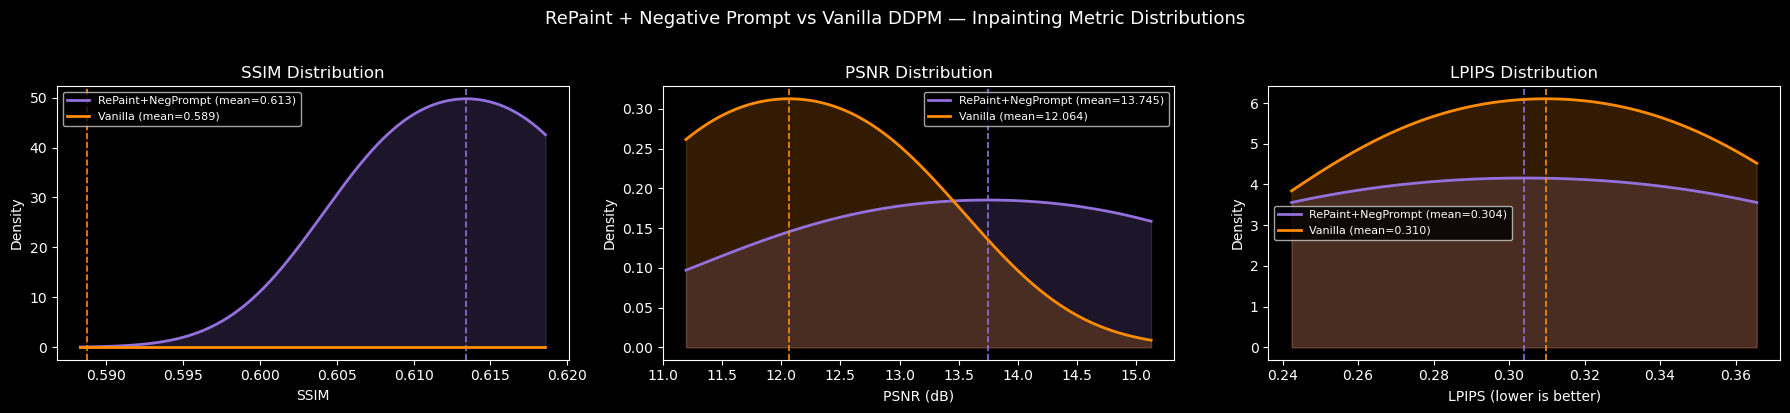

Saved: ./eval_results_repaint/metric_distributions.png


In [25]:
from scipy.stats import gaussian_kde

def print_stats_table(results, label):
    ssim_v  = np.array([r["ssim"]  for r in results])
    psnr_v  = np.array([r["psnr"]  for r in results])
    lpips_v = np.array([r["lpips"] for r in results])
    print(f"\n{'=' * 55}")
    print(f"  {label} — {len(results)} images (inpainted region only)")
    print(f"{'=' * 55}")
    print(f"{'Metric':<10} {'Mean':>10} {'Median':>10} {'Std':>10}")
    print(f"{'-' * 55}")
    print(f"{'SSIM':<10} {ssim_v.mean():>10.4f} {np.median(ssim_v):>10.4f} {ssim_v.std():>10.4f}")
    print(f"{'PSNR':<10} {psnr_v.mean():>10.2f} {np.median(psnr_v):>10.2f} {psnr_v.std():>10.2f}")
    print(f"{'LPIPS':<10} {lpips_v.mean():>10.4f} {np.median(lpips_v):>10.4f} {lpips_v.std():>10.4f}")
    print(f"{'=' * 55}")
    return ssim_v, psnr_v, lpips_v


ssim_rep,  psnr_rep,  lpips_rep  = print_stats_table(results_repaint, "REPAINT + NEGATIVE PROMPT")
ssim_van,  psnr_van,  lpips_van  = print_stats_table(results_vanilla,  "VANILLA  (baseline DDPM)")

COLORS = {"repaint": "mediumpurple", "vanilla": "darkorange"}

def plot_kde_overlay(ax, vals_a, vals_b, label_a, label_b, color_a, color_b, xlabel, title):
    for vals, label, color in [(vals_a, label_a, color_a), (vals_b, label_b, color_b)]:
        if len(vals) < 2:
            ax.axvline(vals.mean(), color=color, linestyle="--", linewidth=1.2,
                       label=f"{label} (mean={vals.mean():.3f})")
        else:
            kde = gaussian_kde(vals, bw_method="scott")
            lo = min(vals_a.min(), vals_b.min()) - 0.05 * max(np.ptp(vals_a), np.ptp(vals_b))
            hi = max(vals_a.max(), vals_b.max()) + 0.05 * max(np.ptp(vals_a), np.ptp(vals_b))
            x = np.linspace(lo, hi, 500)
            y = kde(x)
            ax.plot(x, y, color=color, linewidth=2, label=f"{label} (mean={vals.mean():.3f})")
            ax.fill_between(x, y, alpha=0.20, color=color)
            ax.axvline(vals.mean(), color=color, linestyle="--", linewidth=1.2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)


fig, axes = plt.subplots(1, 3, figsize=(18, 4))
plot_kde_overlay(axes[0], ssim_rep,  ssim_van,  "RePaint+NegPrompt", "Vanilla",
                 COLORS["repaint"], COLORS["vanilla"], "SSIM",  "SSIM Distribution")
plot_kde_overlay(axes[1], psnr_rep,  psnr_van,  "RePaint+NegPrompt", "Vanilla",
                 COLORS["repaint"], COLORS["vanilla"], "PSNR (dB)", "PSNR Distribution")
plot_kde_overlay(axes[2], lpips_rep, lpips_van, "RePaint+NegPrompt", "Vanilla",
                 COLORS["repaint"], COLORS["vanilla"], "LPIPS (lower is better)", "LPIPS Distribution")

plt.suptitle("RePaint + Negative Prompt vs Vanilla DDPM — Inpainting Metric Distributions",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "metric_distributions.png"), dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {os.path.join(RESULTS_DIR, 'metric_distributions.png')}")

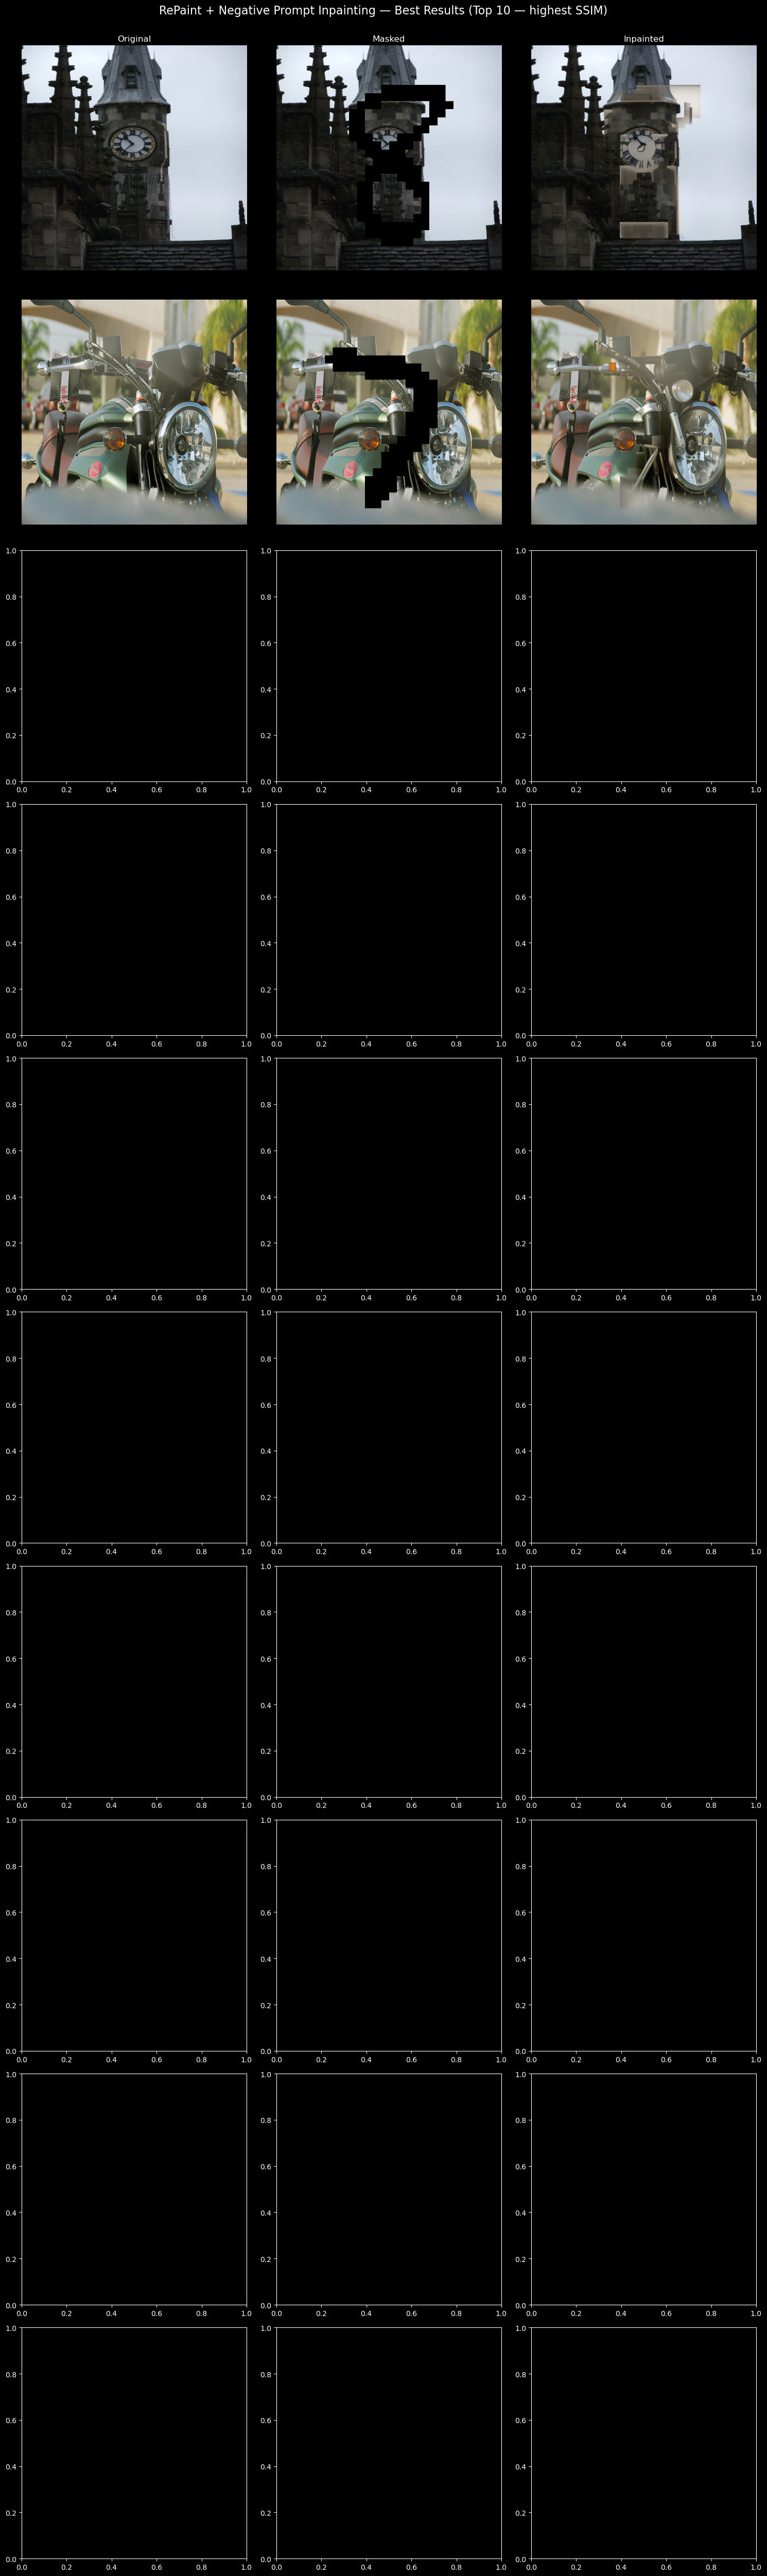

In [26]:
# ---- Visualization helper ----

def show_top10(results, sort_key="ssim", descending=True, title_prefix="", save_path=None):
    """Display and optionally save a 10-row grid: Original | Masked | Inpainted."""
    sorted_r = sorted(results, key=lambda r: r[sort_key], reverse=descending)
    top10 = sorted_r[:10]

    direction = "highest" if descending else "lowest"
    fig, axes = plt.subplots(10, 3, figsize=(15, 50))
    fig.suptitle(f"{title_prefix} (Top 10 — {direction} {sort_key.upper()})", fontsize=16, y=1.0)

    for row, r in enumerate(top10):
        masked_vis = apply_mask_for_display(r["original"], r["mask"])

        axes[row, 0].imshow(r["original"])
        axes[row, 0].set_title("Original" if row == 0 else "")
        axes[row, 0].set_ylabel(
            f"#{r['idx']}\nSSIM={r['ssim']:.3f}\nPSNR={r['psnr']:.1f}\nLPIPS={r['lpips']:.3f}",
            fontsize=9, rotation=0, labelpad=70, va="center",
        )

        axes[row, 1].imshow(masked_vis)
        axes[row, 1].set_title("Masked" if row == 0 else "")
        axes[row, 1].set_xlabel(f'"{ r["caption"]}"', fontsize=8, labelpad=6)

        axes[row, 2].imshow(r["inpainted"])
        axes[row, 2].set_title("Inpainted" if row == 0 else "")

        for col in range(3):
            axes[row, col].axis("off")
        axes[row, 1].xaxis.set_visible(True)
        axes[row, 1].tick_params(bottom=False, labelbottom=True)
        axes[row, 1].set_xticks([])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


# ---- Top 10 BEST — RePaint + Negative Prompt ----
show_top10(
    results_repaint,
    sort_key="ssim", descending=True,
    title_prefix="RePaint + Negative Prompt Inpainting — Best Results",
    save_path=os.path.join(RESULTS_DIR, "top10_best.png"),
)

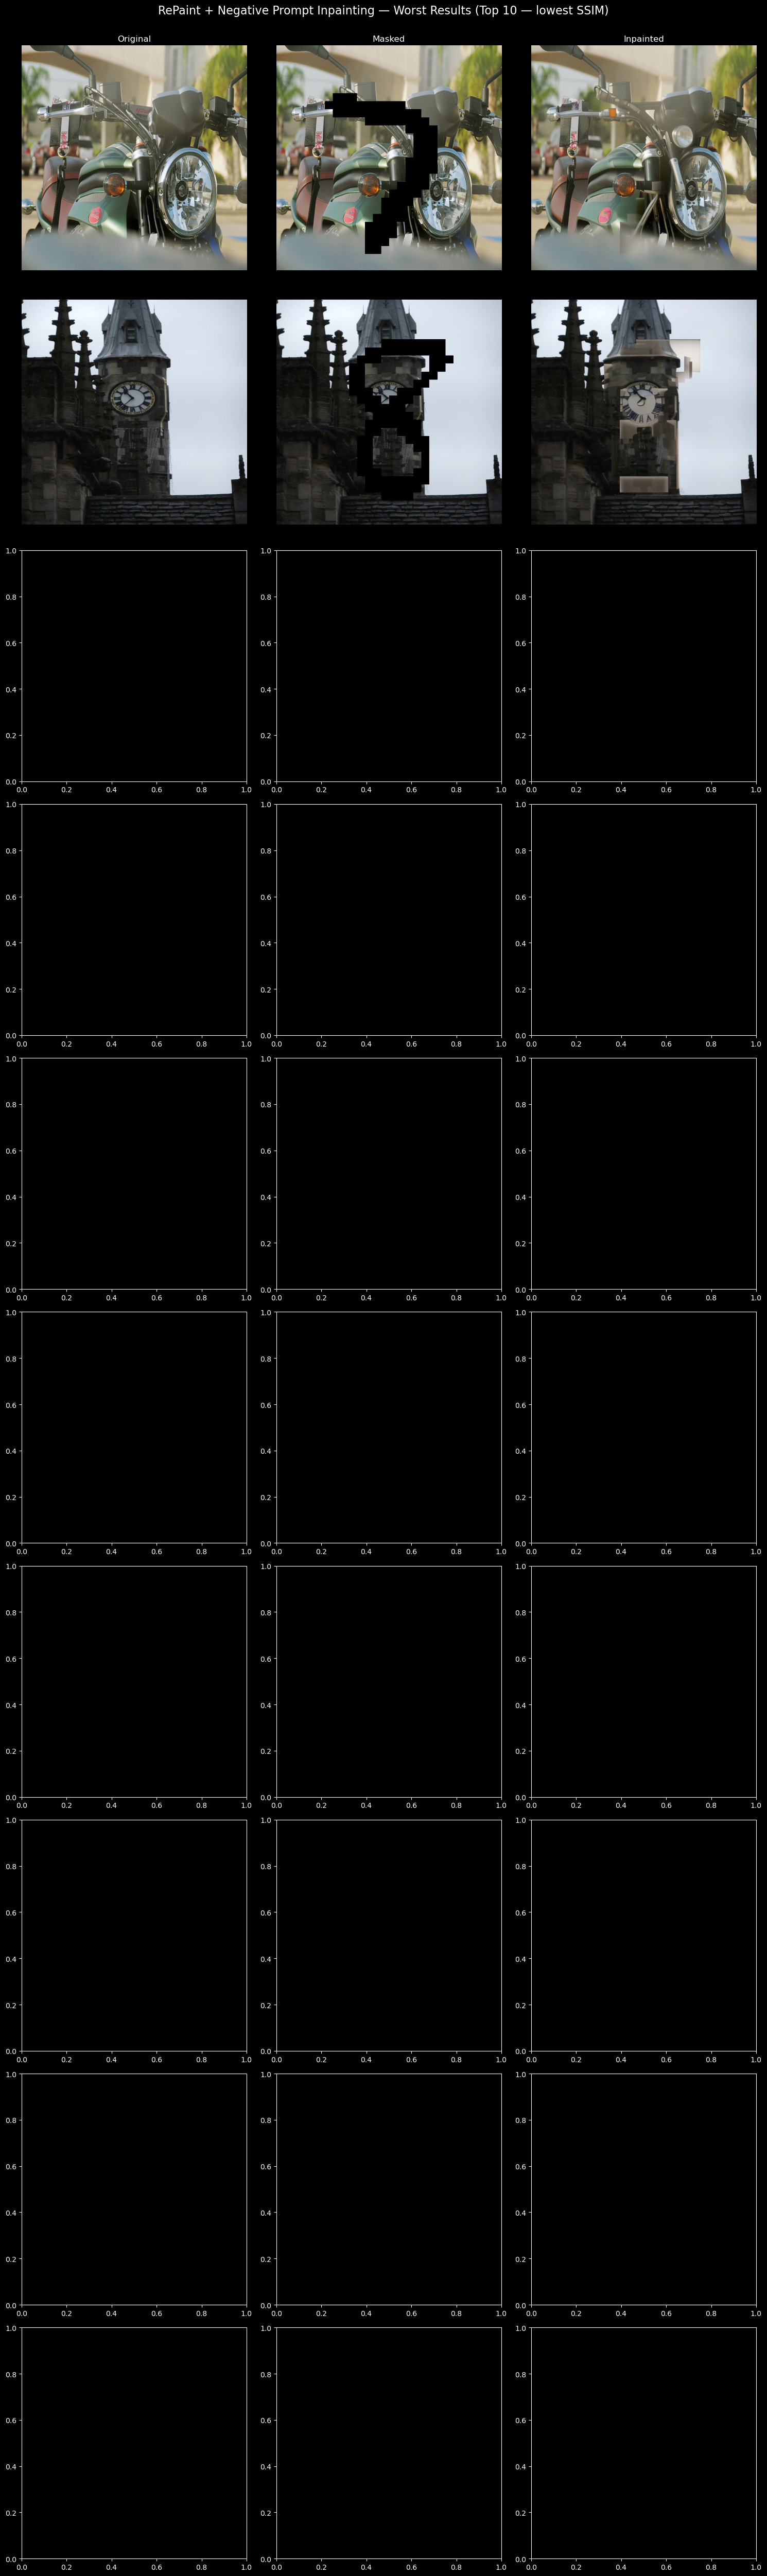

In [27]:
# ---- Top 10 WORST — RePaint + Negative Prompt ----
show_top10(
    results_repaint,
    sort_key="ssim", descending=False,
    title_prefix="RePaint + Negative Prompt Inpainting — Worst Results",
    save_path=os.path.join(RESULTS_DIR, "top10_worst.png"),
)